## Analyzing keio plate 7

This notebook runs the analysis pipeline for the data for Keio plate 7 collected on 08142017.

In [ ]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well, plot_slip_wells, plot_slip_wells_gmm
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values
from SLIP_functions import classify_infections, compute_p_lysis_posterior, compute_MOI_posterior
from keio_names import get_keio_names, pos_to_strain
import seaborn as sns
import pandas as pd
import pymc3 as pm

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = "/media/vanvalen/693d2597-3dbf-41bb-b919-341f714e3199/keio_screen/08.14.2017/keio7"
plate_number = 7

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

INFO (theano.gof.compilelock): Waiting for existing lock by process '25491' (I am process '11818')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/vanvalen/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.4-64/lock_dir


In [ ]:
#Define which wells were used
row_control = ['A']
col_control = [9]

row_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
col_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

p_values_dict_name = os.path.join(root_direc, 'p_values_dict.pkl')
p_values_dict = pickle.load(open(p_values_dict_name, 'rb'))

In [ ]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A9', title = 'Control')
sns.despine()

In [ ]:
#Plot the scatter plot of intensities
wells = []
titles = []
keio_names_array = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        wells += [well]
        titles += [pos_to_strain(keio_names_array, plate_number, well)]
        
plot_slip_wells_gmm(mean_FITC, mean_cherry, wells = wells, titles = titles)
sns.despine()

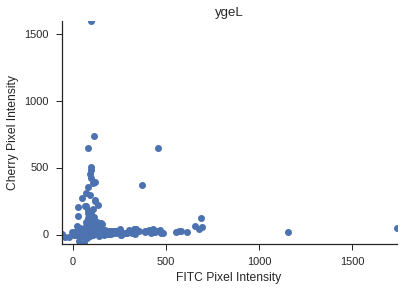

In [16]:
#Print specific wells
well = "B6"
fitc_list = np.array(mean_FITC[well])
cherry_list = np.array(mean_cherry[well])
fig = plt.figure()
plt.plot(fitc_list, cherry_list, 'o')
plt.xlabel('FITC Pixel Intensity')
plt.ylabel('Cherry Pixel Intensity')
plt.title(pos_to_strain(keio_names_array, plate_number, well))
xmax = max(fitc_list)
xmin = min(fitc_list)
ymax = max(cherry_list)
ymin = min(cherry_list)
plt.axis([xmin, xmax, ymin, ymax])
sns.despine()

(96645, 2)
['r', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'g', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'b', 'r', 'g', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'b', 'r', 'g', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'g', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'r'

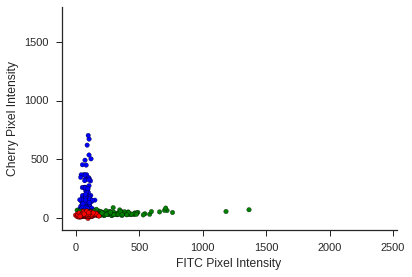

In [28]:
#Print all wells
fitc_list = []
cherry_list = []
for row in row_data:
    for col in col_data:
        well = row + str(col)
        fitc_list += mean_FITC[well]
        cherry_list += mean_cherry[well]
        


from sklearn import mixture

data = np.stack((fitc_list,cherry_list), axis = 1)
print data.shape

gmm = mixture.GMM(n_components = 3).fit(data)
colors = []

well = 'A4'
data_test = np.stack((mean_FITC[well], mean_cherry[well]), axis = 1)
for i in gmm.predict(data_test):
    if i == 0:
        colors += ['r']
    if i == 1: 
        colors += ['g']
    if i == 2:
        colors += ['b']
    if i ==3:
        colors += ['c']
print colors
fig = plt.figure()
ax = plt.gca()
ax.scatter(mean_FITC[well], mean_cherry[well], c = colors)
plt.xlabel('FITC Pixel Intensity')
plt.ylabel('Cherry Pixel Intensity')
xmax = max(fitc_list)
xmin = min(fitc_list)
ymax = max(cherry_list)
ymin = min(cherry_list)
plt.axis([xmin, xmax, ymin, ymax])
sns.despine()

In [17]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

A9 2635
G7 816
G6 1180
G5 1184
G4 1371
G3 2430
G2 1041
G1 250
G9 397
G8 1571
B4 642
B5 1027
B6 735
B7 245
B1 715
B2 574
B3 1331
B8 551
B9 898
E9 437
E8 515
E5 396
E4 392
E7 598
E6 369
E1 414
E3 775
E2 707
H10 7254
H11 1252
H12 1698
F12 533
F10 681
F11 1259
H8 688
H9 6980
H2 674
H3 610
H1 502
H6 1375
H7 680
H4 5431
H5 1576
D10 268
D11 654
D12 231
B12 571
B10 631
B11 2804
C9 890
C8 554
C3 529
C2 614
C1 470
C7 481
C6 1094
C5 593
C4 241
G12 304
G11 275
G10 728
F1 991
F2 258
F3 572
F4 490
F5 302
F6 388
F7 771
F8 901
F9 711
E11 426
E10 365
E12 2588
C12 49
C11 844
C10 590
A11 1789
A10 1721
A12 355
A1 1003
A3 1572
A2 1190
A5 1131
A4 1470
A7 3317
A6 1446
A9 1326
A8 1126
D8 402
D9 360
D6 309
D7 665
D4 690
D5 374
D2 376
D3 632
D1 459


In [18]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A9')

In [19]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
    fraction_infected_list += [fraction_infected]
    
    print well, fraction_infected

G7 0.682598039216
G6 0.797457627119
G5 0.785472972973
G4 0.733770970095
G3 0.633744855967
G2 0.961575408261
G1 0.968
G9 0.866498740554
G8 0.726925525143
B4 0.83800623053
B5 0.790652385589
B6 0.67074829932
B7 0.869387755102
B1 0.976223776224
B2 0.900696864111
B3 0.704733283246
B8 0.787658802178
B9 0.887527839644
E9 0.855835240275
E8 0.671844660194
E5 0.752525252525
E4 0.714285714286
E7 0.829431438127
E6 0.658536585366
E1 0.898550724638
E3 0.766451612903
E2 0.670438472419
H10 0.531982354563
H11 0.97124600639
H12 0.939929328622
F12 0.932457786116
F10 0.928046989721
F11 0.670373312153
H8 0.984011627907
H9 0.643553008596
H2 0.974777448071
H3 0.968852459016
H1 0.986055776892
H6 0.805090909091
H7 0.966176470588
H4 0.608359418155
H5 0.828680203046
D10 0.80223880597
D11 0.762996941896
D12 0.943722943723
B12 0.985989492119
B10 0.841521394612
B11 0.656562054208
C9 0.676404494382
C8 0.79963898917
C3 0.771266540643
C2 0.918566775244
C1 0.985106382979
C7 0.68814968815
C6 0.583180987203
C5 0.77571669

pepT 0 133
tesA 0 127
ppdD 2 93
ynfL 0 220
ybhD 0 130
None 2 182
None 6 440
wza 0 137
None 0 188
ybhC 0 230
cirA 0 136
None 1 150
None 0 29
None 1 27
None 5 98
dbpA 0 61
None 0 33
ygeL 15 40
yraJ 0 8
fiu 1 26
fhuE 0 28
ycdS 0 15
None 12 129
None 0 119
umuD 1 27
dacA 4 11
None 2 22
hepA 1 5
yeaT 2 15
None 3 53
None 1 6
cusC 1 22
None 0 7
yiaT 0 9
mltA 2 17
ldcA 0 18
dacC 0 9
pepD 7 19
hrpB 6 27
yeiE 3 17
gcd 5 9
None 6 51
nlpB 1 7
yeaY 0 3
mltB 1 28
None 0 12
sohB 0 18
potH 10 24
prpR 5 33
lhr 4 8
None 4 8
None 2 4
yqcB 1 26
ydeT 2 7
ompA 0 23
slp 0 13
None 1 8
None 21 140
None 1 88
clpA 0 1
clpP 2 11
rhlB 0 1
yiaU 1 10
cybC 0 1
yqeI 1 8
fimB 4 18
ompC 2 9
None 1 36
pal 1 20
None 0 22
None 0 9
pepN 5 55
clpX 13 86
srmB 8 102
yidZ 4 58
None 5 48
None 7 21
fimD 11 74
ompF 0 12
nlpE 1 36
pgpB 0 11
None 0 19
ydcP 0 93
hyaD 0 58
lon 0 38
yoaA 52 422
yjiE 0 13
glpX 2 73
ygeF 0 45
fimE 0 34
ompN 81 469
fadL 33 337
ompT 1 108
ydeU 7 129


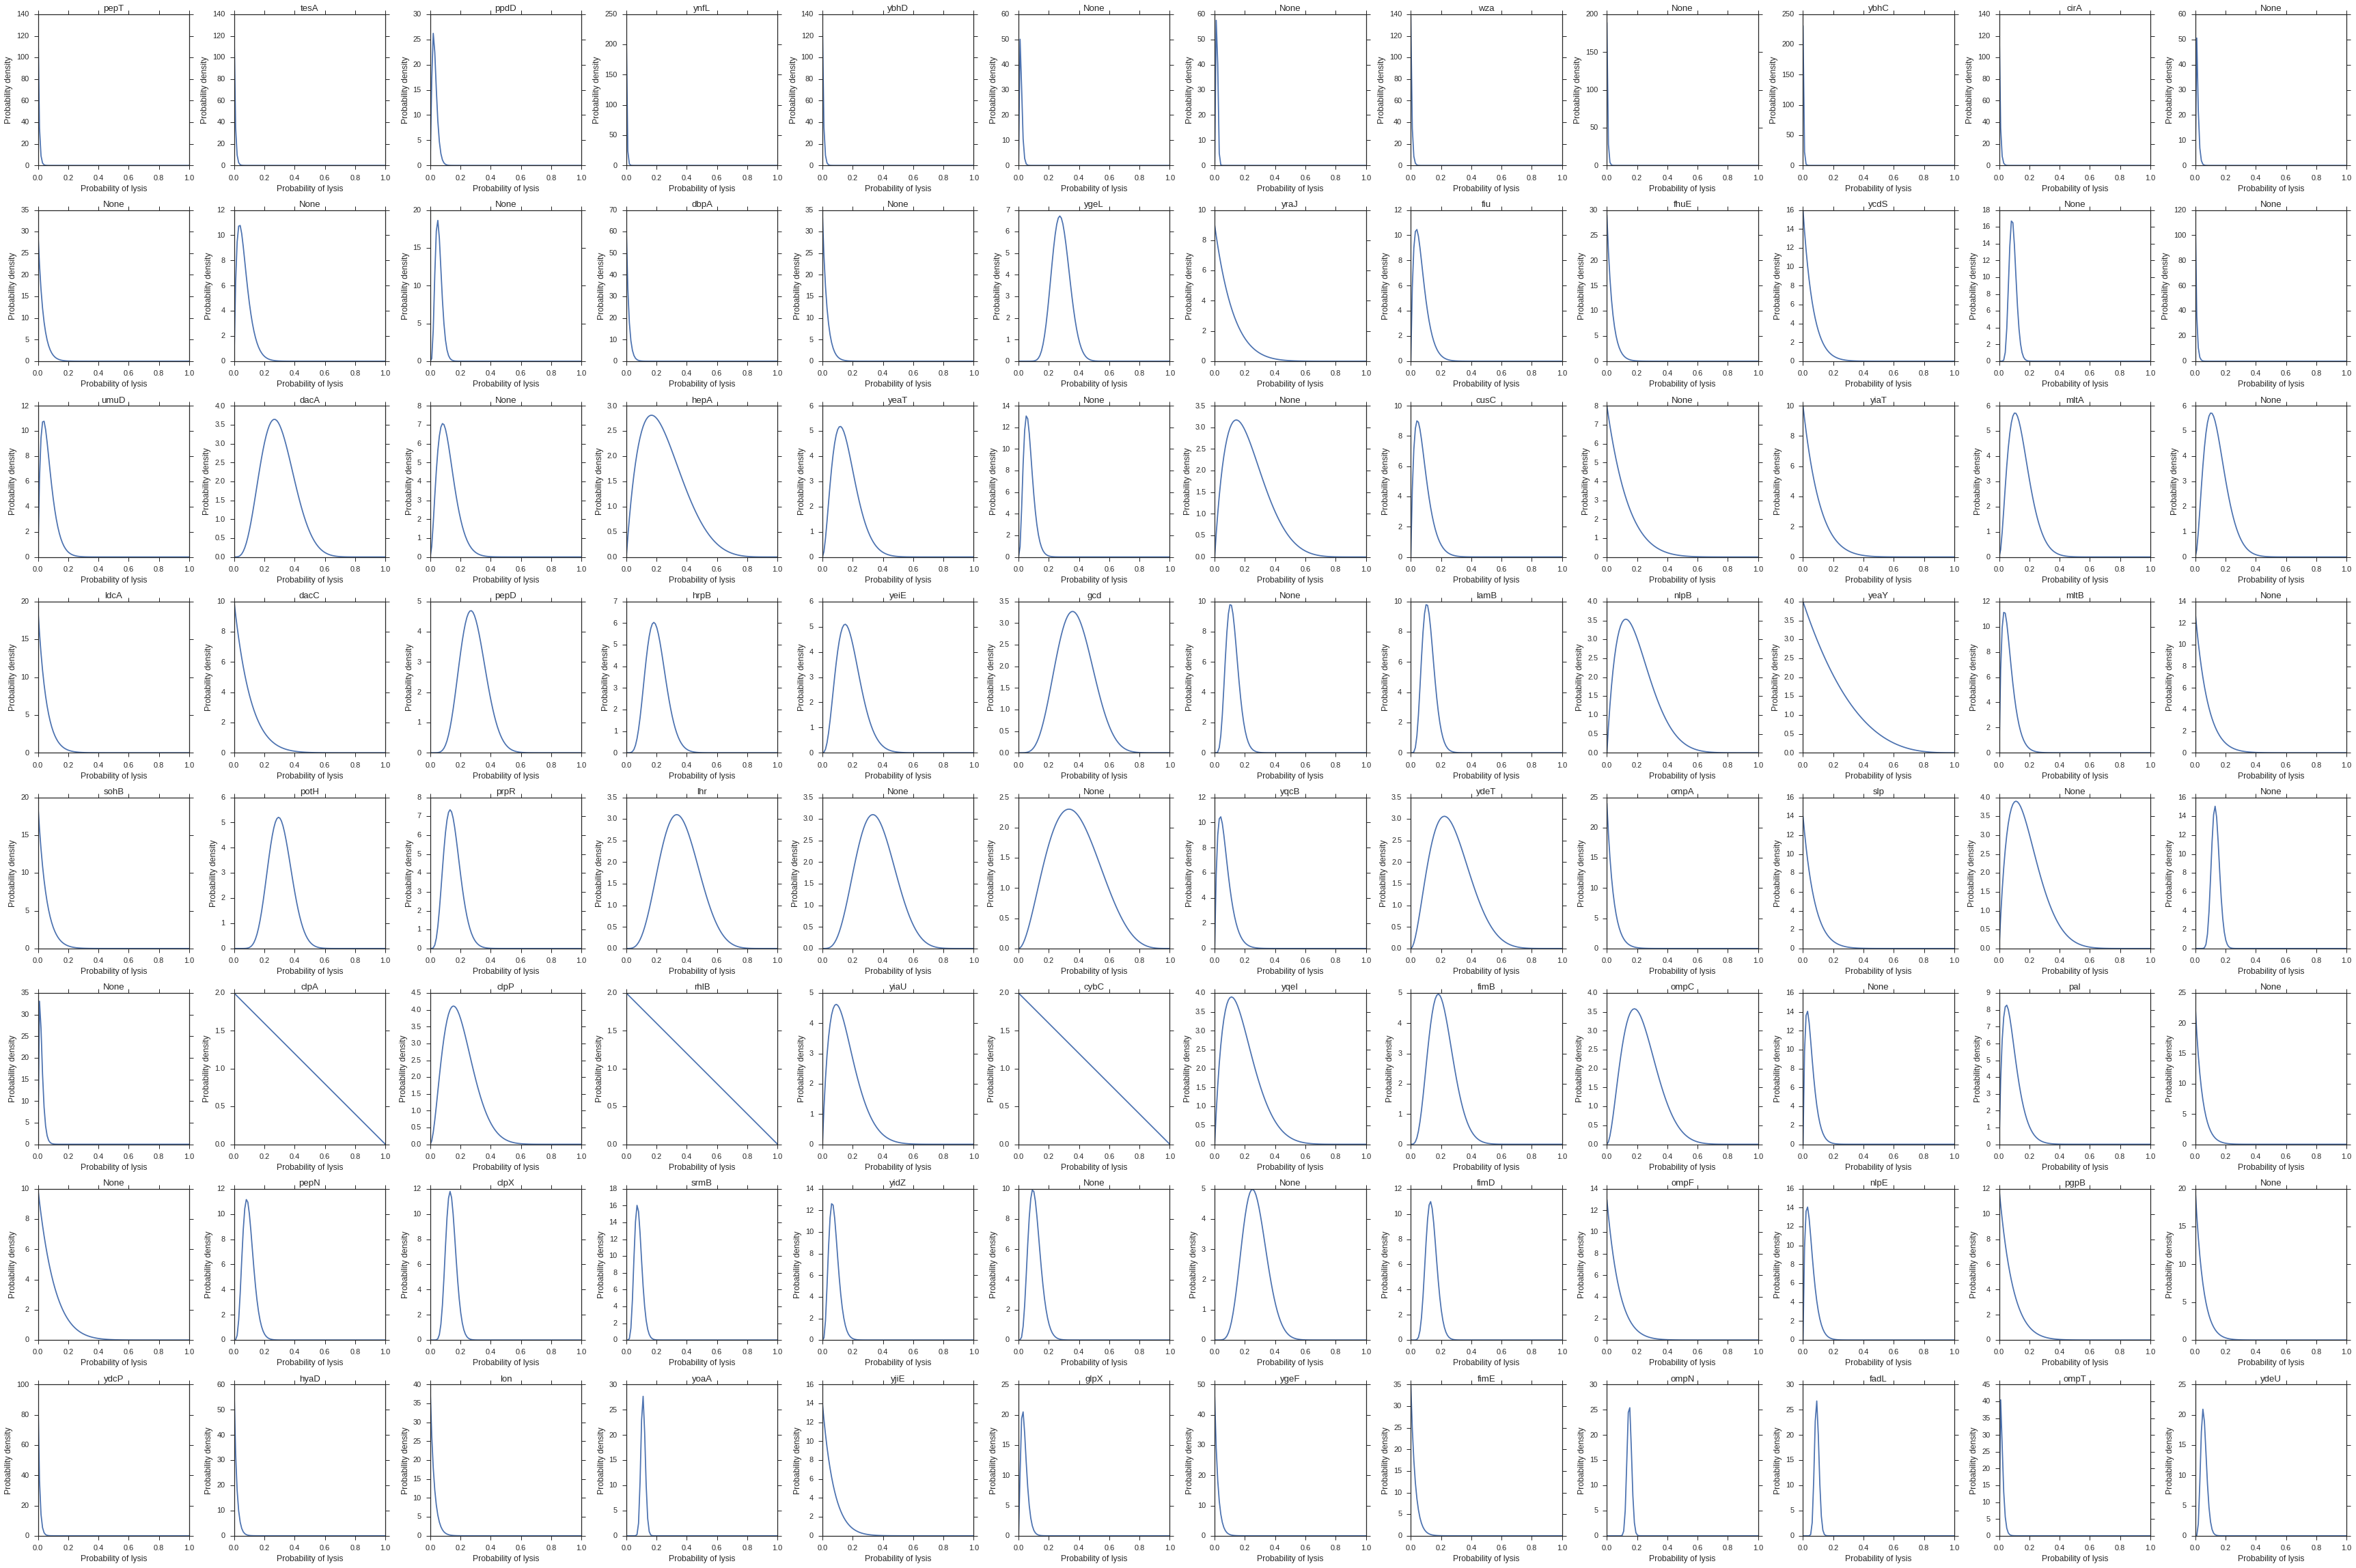

In [20]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A9'])
cherry_control_array = np.array(mean_cherry_control['A9'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

def compute_p_lysis_posterior(N_lysis, N_lysogeny):
    x = np.linspace(0,1,100)
    posterior= scipy.stats.beta.pdf(x, 1+N_lysis, 1+N_lysogeny)
    return x, posterior

# d = classify_infections(kernel_fitc, kernel_cherry, p_values_dict, rows = row_data, cols = col_data)

kn = get_keio_names()
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)
#         ax.set_xlim([-0.05, 1.05])
#         ax.set_ylim([-0.05, 1.05])

        d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            print well_name, counter, len(p_fitc)-counter
            x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()
    

cpxA 31 2


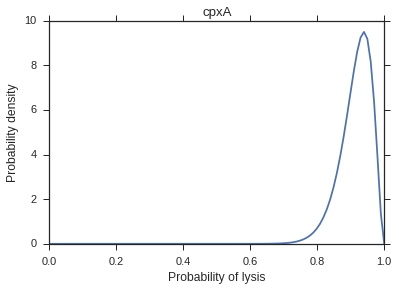

In [21]:
well = "D11"
        
well_name = pos_to_strain(kn, plate = plate_number, pos = well)
p_value = p_values_dict[well]
infected_cells = np.where(p_value < 0.01)[0]
fitc_list = np.array(mean_FITC[well])[infected_cells]
cherry_list = np.array(mean_cherry[well])[infected_cells]

p_fitc = []
p_cherry = []
for fitc, cherry in zip(fitc_list, cherry_list):
    p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
    p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

# Remove double positives
p_fitc_new = []
p_cherry_new = []
fitc_list_new = []
cherry_list_new = []
for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
    if (p_f < 0.85 and c > 50) or p_c < 0.85:
        p_fitc_new += [p_f]
        p_cherry_new += [p_c]
        fitc_list_new += [f]
        cherry_list_new += [c]

p_fitc = p_fitc_new
p_cherry = p_cherry_new
fitc_list = fitc_list_new
cherry_list = cherry_list_new

counter = 0
for p_f, p_c in zip(p_fitc, p_cherry):
    if p_f > p_c:
        counter += 1
                
if len(p_fitc) > 0:
    #Uncomment to print p_lysis
    #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
    print well_name, counter, len(p_fitc)-counter
    x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)

    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1
    fig = plt.figure()
    axes = plt.gca()
    axes.plot(x, posterior)
    axes.set_xlim([0, 1])
    axes.set_xlabel('Probability of lysis')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)

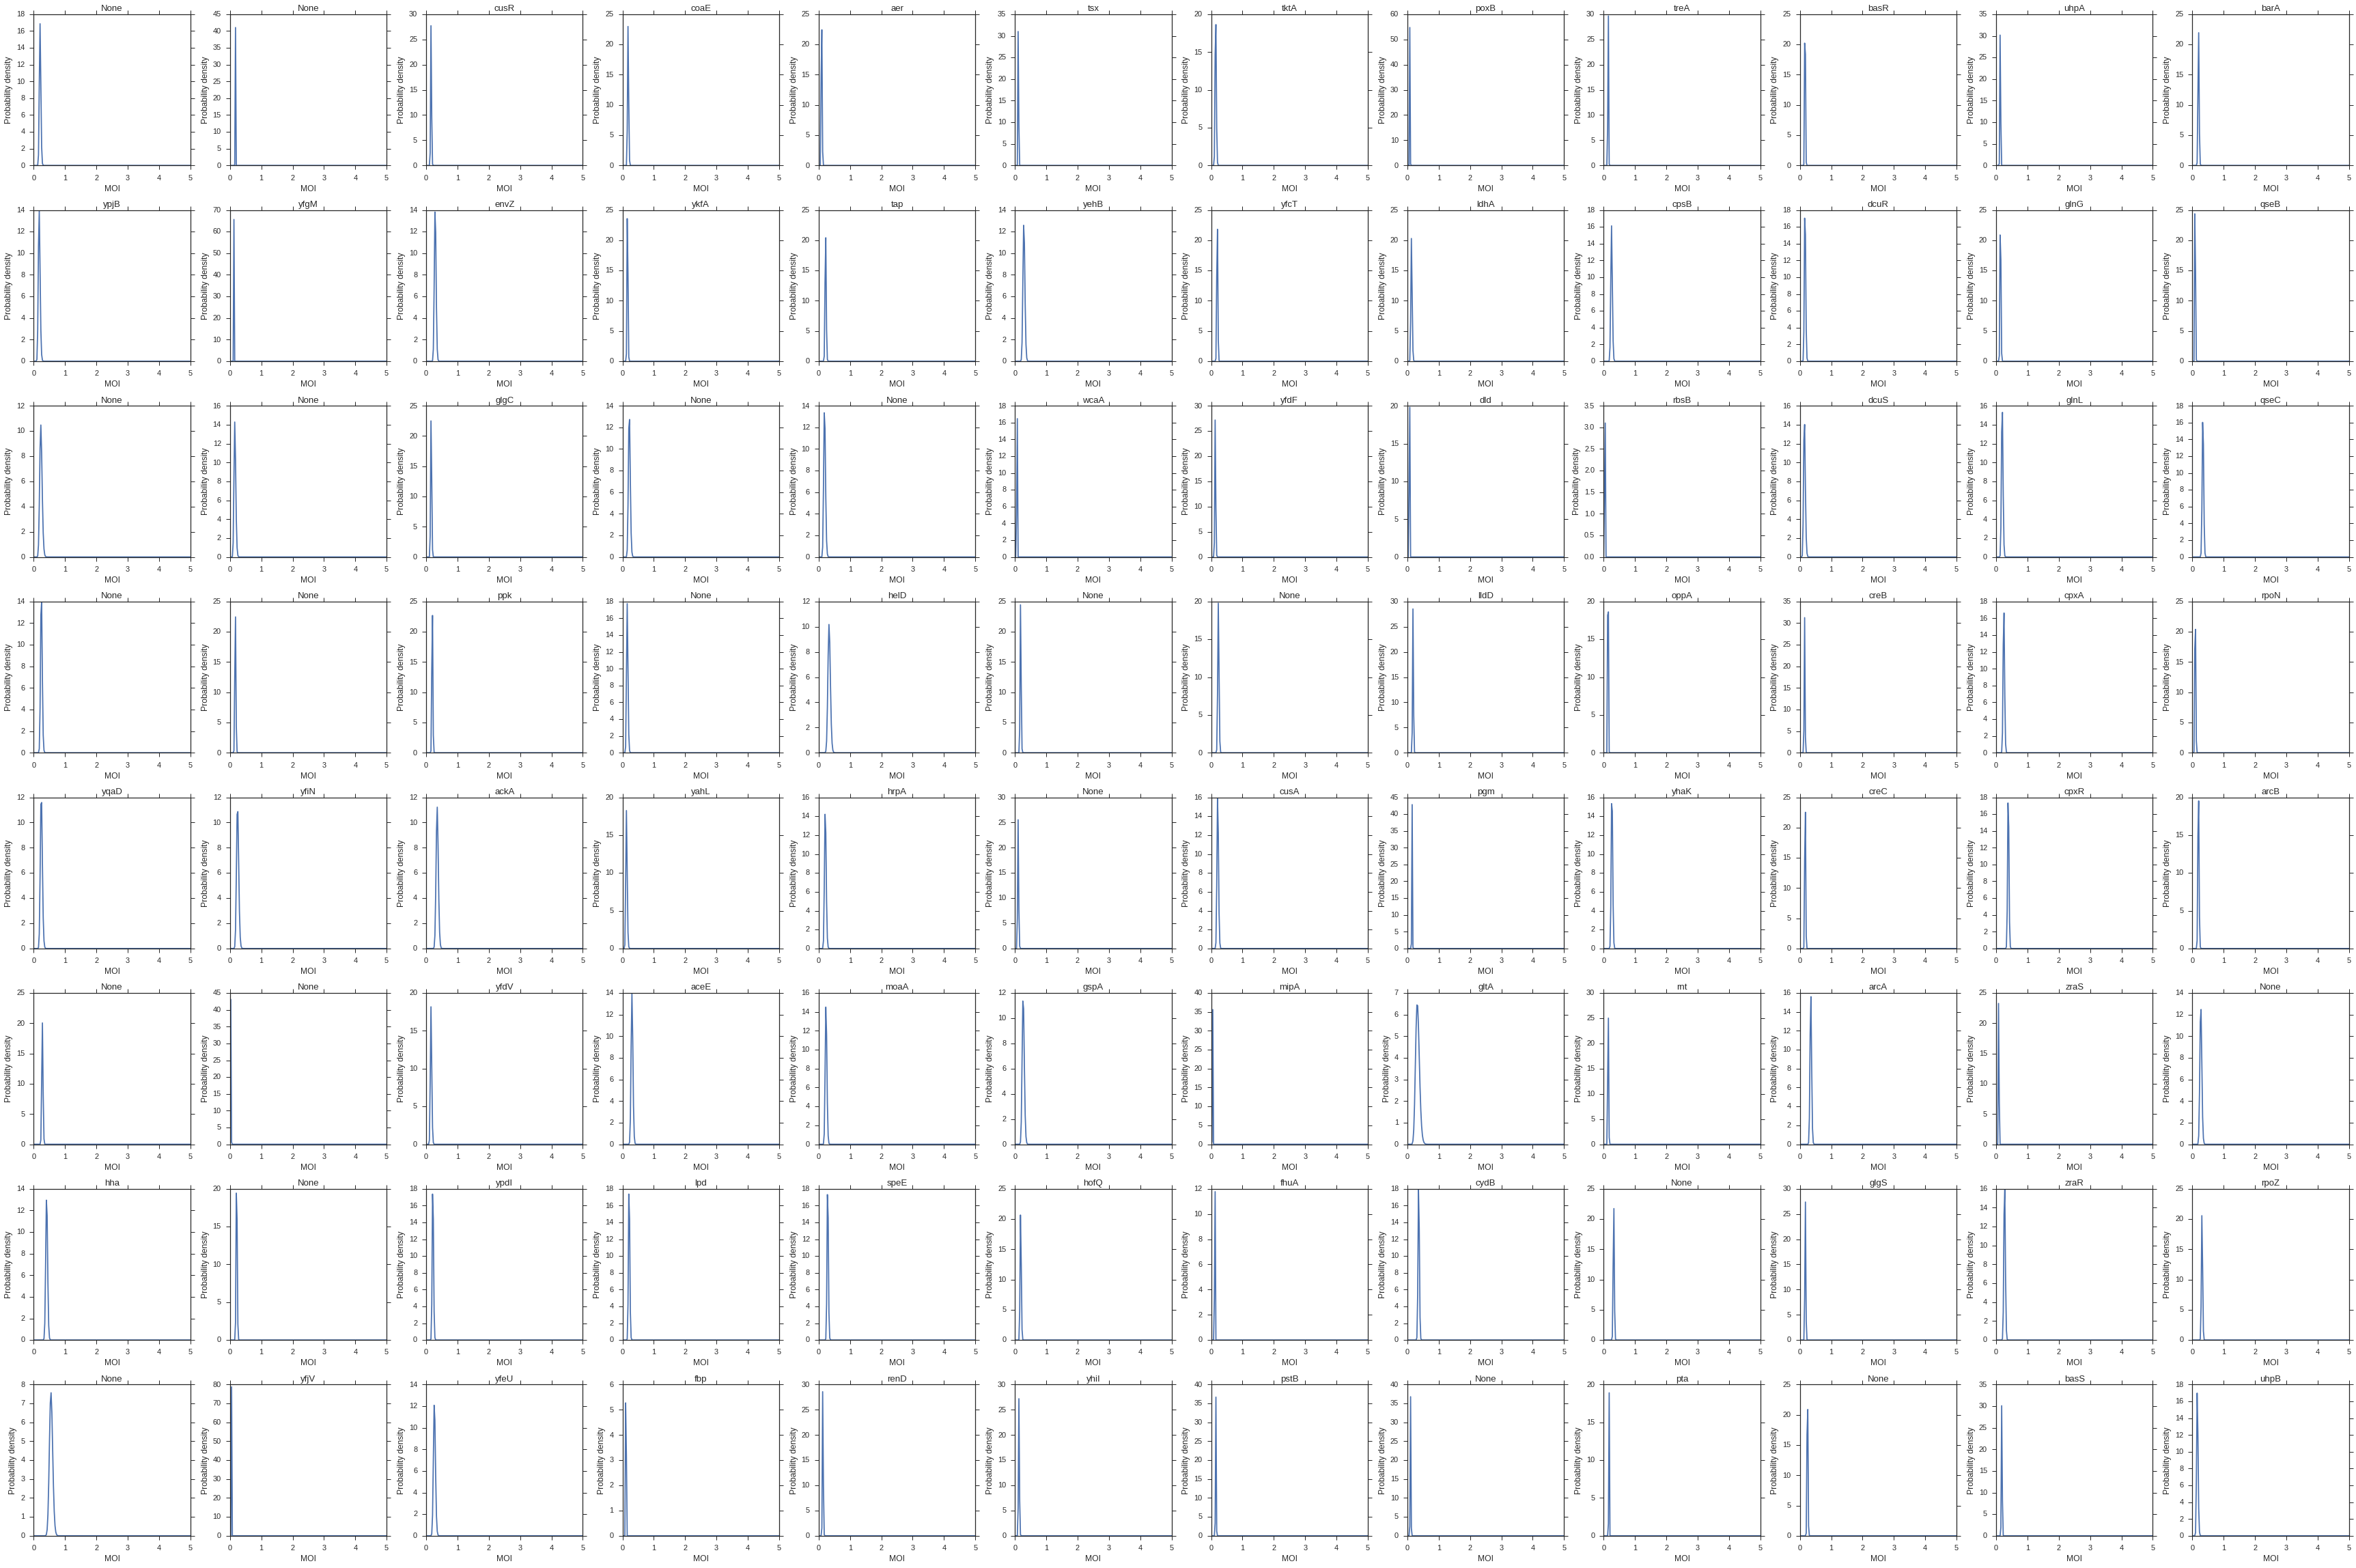

In [22]:
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()

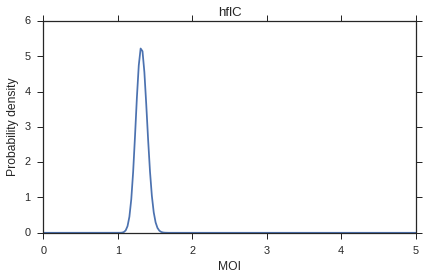

In [20]:
fig = plt.figure()
axes = plt.gca()

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

well = "B6"
        
well_name = pos_to_strain(kn, plate = plate_number, pos = well)
p_value = p_values_dict[well]
infected_cells = np.where(p_value < 0.01)[0]
fitc_list = np.array(mean_FITC[well])[infected_cells]
cherry_list = np.array(mean_cherry[well])[infected_cells]

p_fitc = []
p_cherry = []
for fitc, cherry in zip(fitc_list, cherry_list):
    p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
    p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

# Remove double positives
p_fitc_new = []
p_cherry_new = []
fitc_list_new = []
cherry_list_new = []
for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
    if (p_f < 0.85 and c > 50) or p_c < 0.85:
        p_fitc_new += [p_f]
        p_cherry_new += [p_c]
        fitc_list_new += [f]
        cherry_list_new += [c]

p_fitc = p_fitc_new
p_cherry = p_cherry_new
fitc_list = fitc_list_new
cherry_list = cherry_list_new

counter = 0
for p_f, p_c in zip(p_fitc, p_cherry):
    if p_f > p_c:
        counter += 1

if len(p_fitc) > 0:
    #Uncomment to print p_lysis
    #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
    x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])

    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1

    axes.plot(x, posterior)
    axes.set_xlim([0, 5])
    axes.set_xlabel('MOI')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)
else:    
    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1

    axes.plot(x, posterior)
    axes.set_xlim([0, 5])
    axes.set_xlabel('MOI')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)
            
plt.tight_layout()